In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD, GRSCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = 'cuda:2'


BUILDER = 'transformer'
builder_name = "Transformer Encoder"

LR = 3e-4
EPOCHS = 15



exp_name = '2_GATConvGNNTRANSFORMER_LOGE_SGD_GRSCD_06_05_22'
model_filename = f'/grscd_gnn/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_grscd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GRSCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_grscd_paths(config.DATA_DIR,'test')

test_dataset = GRSCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=False,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GRSCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [13]:
print(len(train_dataset))
print(len(test_dataset))
print(len(aug_dataset))

4000
4000
4000


#### Model

In [14]:
from torchvision import models

In [15]:
torch.cuda.empty_cache()

In [16]:
model = GATConvGNN(7, 1024, 2, 4, 0.7, adjacency_builder = BUILDER).to(device)

Transformer has 4 blocks


In [17]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [18]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [19]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 125/125 [00:29<00:00,  4.25it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 50.08% Train Loss: 3.1641 Test acc: 96.05% Test Loss: 1.0162


100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 95.12% Train Loss: 0.4494 Test acc: 97.30% Test Loss: 0.7218


100%|██████████| 125/125 [00:28<00:00,  4.41it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 98.88% Train Loss: 0.1272 Test acc: 97.95% Test Loss: 0.6468


100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


EPOCH 4: Train acc: 99.30% Train Loss: 0.0690 Test acc: 96.23% Test Loss: 0.7177


100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


EPOCH 5: Train acc: 99.72% Train Loss: 0.0313 Test acc: 96.83% Test Loss: 0.6950


100%|██████████| 125/125 [00:28<00:00,  4.37it/s]


EPOCH 6: Train acc: 99.65% Train Loss: 0.0307 Test acc: 96.23% Test Loss: 0.7340


100%|██████████| 125/125 [00:28<00:00,  4.35it/s]


EPOCH 7: Train acc: 99.95% Train Loss: 0.0139 Test acc: 96.12% Test Loss: 0.7114


100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


EPOCH 8: Train acc: 99.88% Train Loss: 0.0141 Test acc: 97.02% Test Loss: 0.6619


100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Saved best parameters at epoch 9
EPOCH 9: Train acc: 99.95% Train Loss: 0.0127 Test acc: 98.30% Test Loss: 0.6522


100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


EPOCH 10: Train acc: 99.90% Train Loss: 0.0138 Test acc: 95.83% Test Loss: 0.7204


100%|██████████| 125/125 [00:28<00:00,  4.44it/s]


EPOCH 11: Train acc: 99.98% Train Loss: 0.0082 Test acc: 95.73% Test Loss: 0.7210


100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


EPOCH 12: Train acc: 99.88% Train Loss: 0.0111 Test acc: 96.17% Test Loss: 0.7048


100%|██████████| 125/125 [00:28<00:00,  4.45it/s]


EPOCH 13: Train acc: 99.98% Train Loss: 0.0074 Test acc: 95.47% Test Loss: 0.7219


100%|██████████| 125/125 [00:28<00:00,  4.41it/s]


EPOCH 14: Train acc: 99.92% Train Loss: 0.0081 Test acc: 95.50% Test Loss: 0.7297


100%|██████████| 125/125 [00:28<00:00,  4.40it/s]

EPOCH 15: Train acc: 99.92% Train Loss: 0.0079 Test acc: 94.70% Test Loss: 0.7618


In [20]:
wandb.finish()

test/test_accuracy,▄▆▇▄▅▄▄▆█▃▃▄▃▃▁
test/test_loss,█▂▁▂▂▃▂▁▁▂▂▂▂▃▃
train/train_accuracy,▁▇█████████████
train/train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test/test_accuracy,0.947
test/test_loss,0.76183
train/train_accuracy,0.99925
train/train_loss,0.00791


In [21]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [22]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


In [23]:
accuracy_score(test_targets, test_preds)

0.983

---

### Accuracy per class and confusion matrix

In [24]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [25]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [26]:
class_acc

{'1_cumulus': 0.9919786096256684,
 '2_altocumulus': 0.9848942598187311,
 '3_cirrus': 0.9524517087667161,
 '4_clearsky': 0.9941860465116279,
 '5_stratocumulus': 0.9978401727861771,
 '6_cumulonimbus': 1.0,
 '7_mixed': 0.9607843137254902}

Global Test accuracy 0.983


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

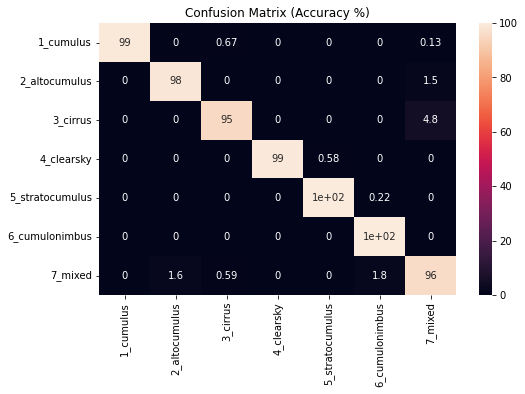

In [27]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)